In [1]:
# Imports and settings
import numpy as np
import matplotlib.pyplot as plt
print(plt.style.available)
# Use an available style
plt.style.use('seaborn-v0_8-white')  # or 'seaborn-v0_8-whitegrid'
plt.rcParams.update({'pdf.fonttype': 'truetype'})


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


basic simulation using random values of R and S for example

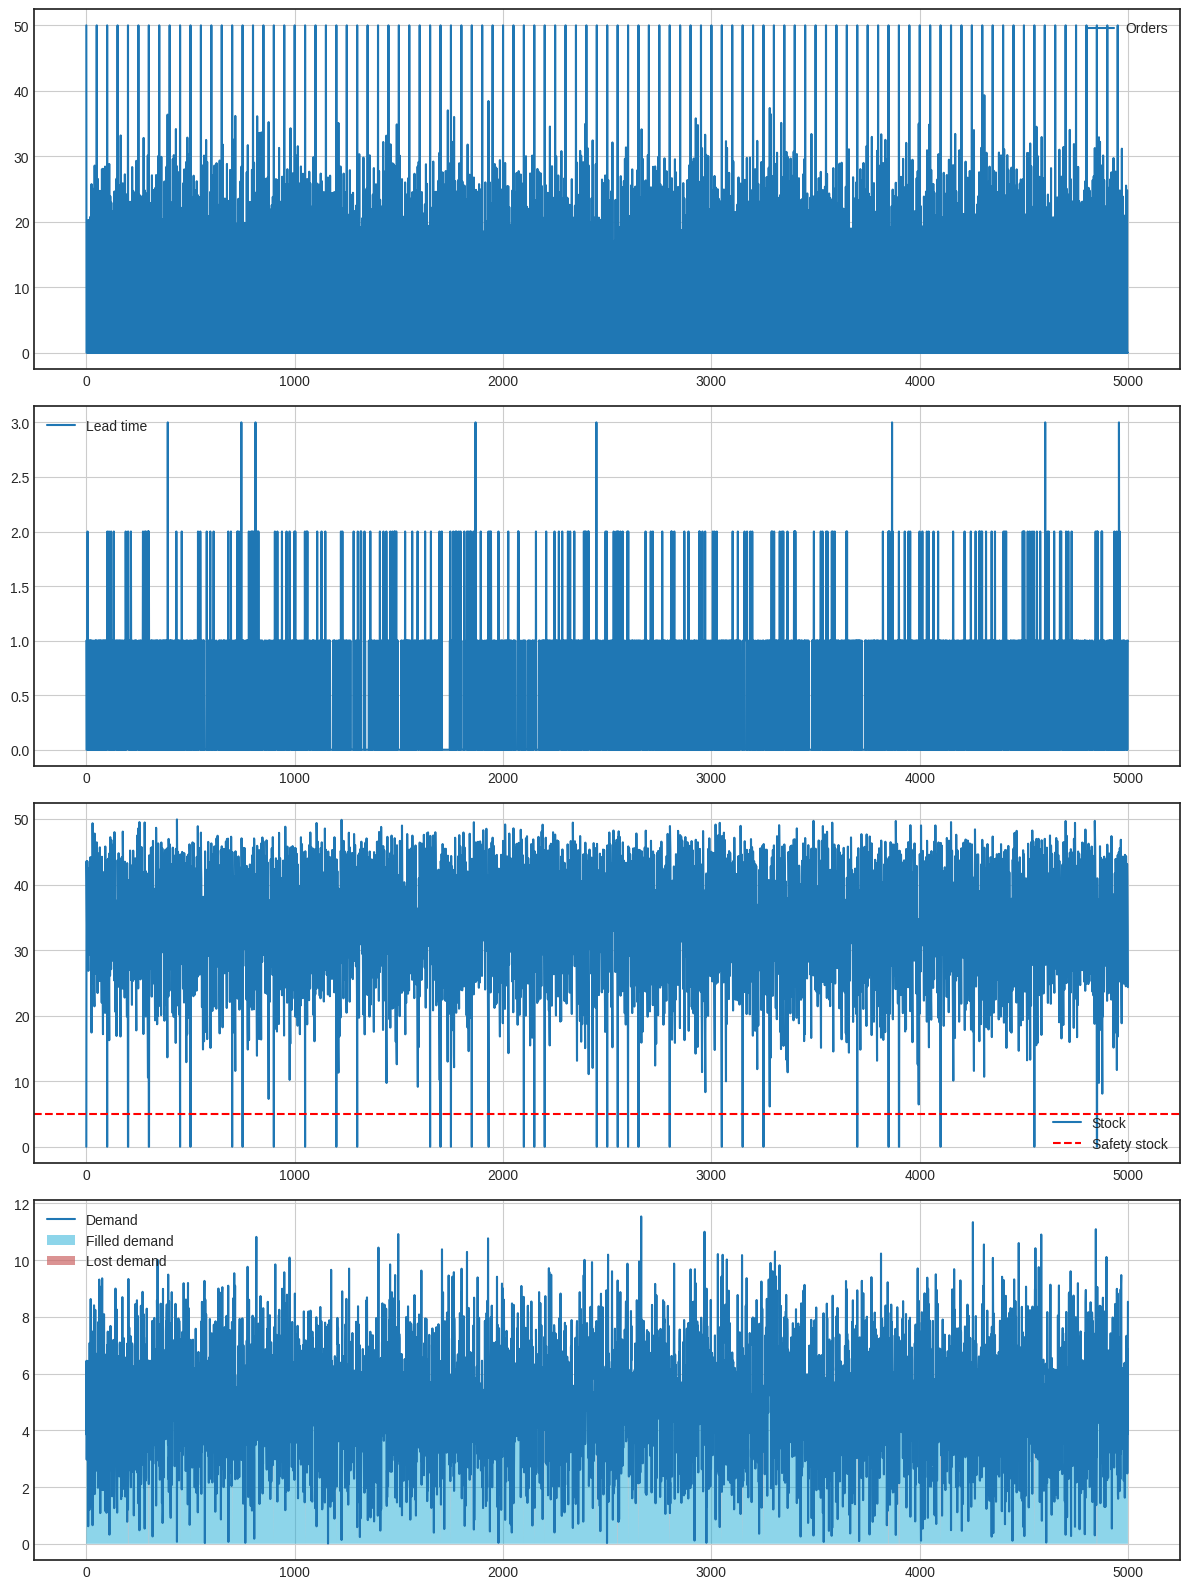

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


#
# Random generators
#
class Generator:
    def next(self):
        pass


class ConstantGenerator(Generator):
    def __init__(self, mu):
        self.mu = mu


    def next(self):
        return self.mu


class NormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma


    def next(self):
        return np.random.normal(self.mu, self.sigma, 1)[0]


class FoldedNormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma


    def next(self):
        return abs(np.random.normal(self.mu, self.sigma, 1)[0])


class HalfNormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma


    def next(self):
        return abs(np.random.normal(self.mu, self.sigma, 1)[0])


#
# Inventory policies
#
class InventoryPolicy:
    def get_order_quantity(self, supply_chain):
        pass


class RSInventoryPolicy(InventoryPolicy):
    def __init__(self, R, S):
        self.S = S
        self.R = R

    def __str__(self):
        return f'(R={self.R}, S={self.S}'

    def get_order_quantity(self, supply_chain):
        net_inventory = supply_chain.get_stock() + supply_chain.get_intransit()
        if supply_chain.t % self.R == 0 and net_inventory <= self.S:
            return self.S - net_inventory
        else:
            return 0


#
# Supply chain simulator
#
class SupplyChain:
    def __init__(self, config):
        self.orders = []
        self.stock = []
        self.demand = []
        self.lead_times = []
        self.t = 0


        self.fixed_tx_cost = config['fixed_transaction_cost']
        self.variable_tx_cost = config['variable_transaction_cost']
        self.holding_cost = config['holding_cost']
        self.demand_generator = config['demand_generator']
        self.lead_time_generator = config['lead_time_generator']
        self.policy = config['policy']


        # auxiliary variables for efficiency calculations
        self._filled_demand = []
        self._fixed_tx_costs = []
        self._variable_tx_costs = []
        self._holding_costs = []


    def get_stock(self):
        if not self.stock:
            return 0
        else:
            return self.stock[-1]


    def get_intransit(self):
        in_transit = 0
        for i in range(self.t):
            if self.t <= i + self.lead_times[i]:
                in_transit += self.orders[i]
        return in_transit


    def process_demand(self):
        demand = self.demand_generator.next()
        self.demand.append(demand)


        filled_demand = min(demand, self.stock[self.t])
        self.stock[self.t] -= filled_demand


        self._filled_demand.append(filled_demand)


    def place_order(self):
        order = self.policy.get_order_quantity(self)
        self.orders.append(order)


        lead_time = int(self.lead_time_generator.next())
        self.lead_times.append(lead_time)


    def procees_orders(self):
        new_stock = 0
        for i in range(self.t + 1):
            if self.t == i + self.lead_times[i]:
                new_stock += self.orders[i]


        self.stock.append(self.get_stock() + new_stock)


    def update_costs(self):
        if self.orders[self.t] != 0:
            self._fixed_tx_costs.append(self.fixed_tx_cost)
            self._variable_tx_costs.append(self.orders[self.t] * self.variable_tx_cost)
        else:
            self._fixed_tx_costs.append(0)
            self._variable_tx_costs.append(0)
        self._holding_costs.append(self.stock[self.t] * self.holding_cost)


    def act(self):
        self.place_order()
        self.procees_orders()
        self.process_demand()
        self.update_costs()
        self.t += 1


def plot_all_episodes(all_data):
    fig, ax = plt.subplots(4, 1, figsize=(12, 16))


    x = np.arange(len(all_data['orders']))
    ax[0].plot(x, all_data['orders'], label='Orders')
    ax[1].plot(x, all_data['lead_times'], label='Lead time')


    ax[2].plot(x, all_data['stock'], label='Stock')
    ax[2].axhline(5, color='red', label='Safety stock', linestyle='--')


    ax[3].plot(x, all_data['demand'], label='Demand')
    ax[3].fill_between(x, np.zeros(len(x)), all_data['filled_demand'], facecolor="#1DACD6", alpha=.5, label='Filled demand')
    ax[3].fill_between(x, all_data['filled_demand'], all_data['demand'], facecolor="#CC6666", alpha=.7, label='Lost demand')


    for axi in ax:
        axi.grid(True)
        axi.legend()


    plt.tight_layout()
    plt.show()


##########################################################################


# Configuration
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': HalfNormalGenerator(5, 2),
    'lead_time_generator': HalfNormalGenerator(0, 1),
    'policy': RSInventoryPolicy(5, 50)
}


# Run simulation for multiple episodes
episodes = 100
steps_per_episode = 50
all_data = {
    'orders': [],
    'lead_times': [],
    'stock': [],
    'demand': [],
    'filled_demand': [],
}


for episode in range(episodes):
    simulator = SupplyChain(config)
    for t in range(steps_per_episode):
        simulator.act()


    # Collect data for plotting
    all_data['orders'].extend(simulator.orders)
    all_data['lead_times'].extend(simulator.lead_times)
    all_data['stock'].extend(simulator.stock)
    all_data['demand'].extend(simulator.demand)
    all_data['filled_demand'].extend(simulator._filled_demand)


# Plot consolidated data for all episodes
plot_all_episodes(all_data)


HAVE TO CORRECT IT -example to show simulations in 10 graphs (each graph has 10 episodes)

NameError: name 'sQInventoryPolicy' is not defined

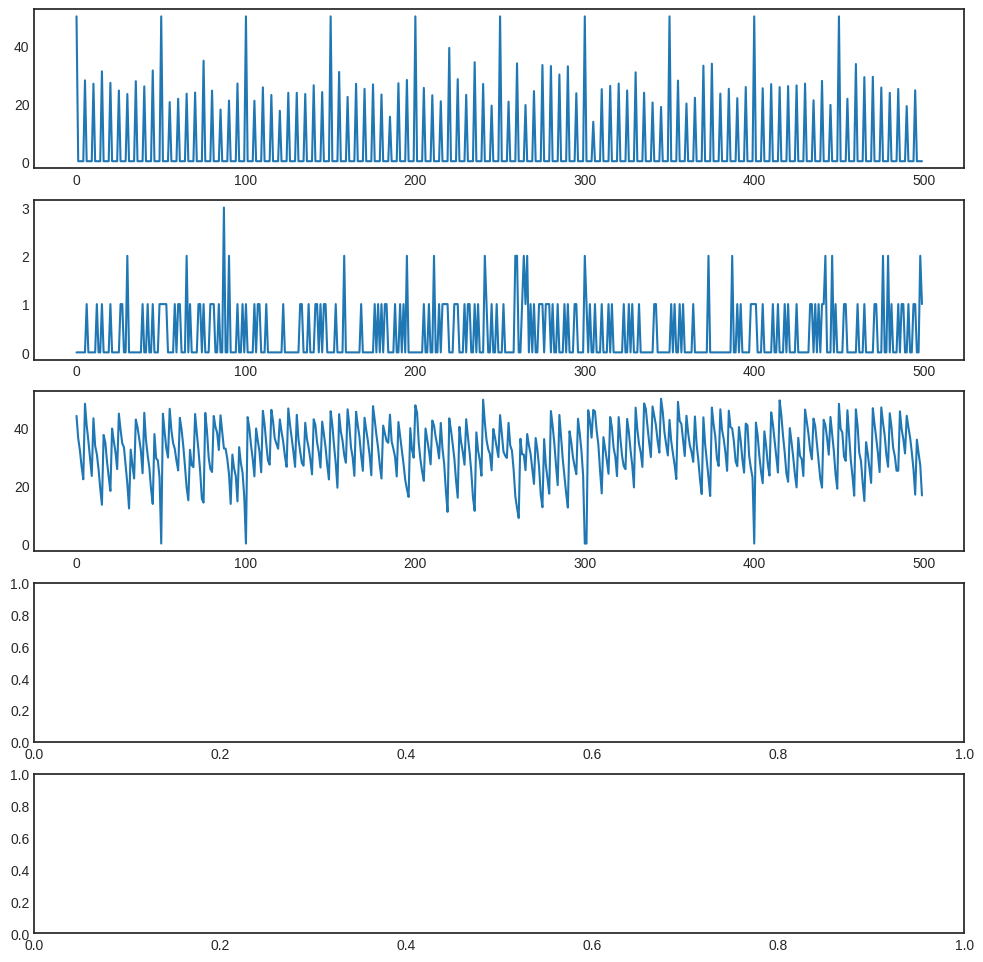

In [4]:
def plot_supply_chain_detail(supply_chain, title):
    fig, ax = plt.subplots(5, 1, figsize=(12, 12))
    x = np.arange(supply_chain.t)
    ax[0].plot(x, supply_chain.orders, label='Orders')
    ax[1].plot(x, supply_chain.lead_times, label='Lead time')

    ax[2].plot(x, supply_chain.stock, label='Stock')
    if isinstance(supply_chain.policy, sQInventoryPolicy):
        ax[2].axhline(supply_chain.policy.s, color='red', label='Safety stock')
    if isinstance(supply_chain.policy, RSInventoryPolicy):
        ax[2].axhline(supply_chain.policy.S, color='red', label='Up-to level')

    ax[3].plot(x, supply_chain.demand, label='Demand')
    ax[3].fill_between(x, np.zeros(len(x)), supply_chain._filled_demand, facecolor="#1DACD6", alpha=.5, label='Filled demand')
    ax[3].fill_between(x, supply_chain._filled_demand, supply_chain.demand, facecolor="#CC6666", alpha=.7, label='Lost demand')

    # If these lists are shorter than x, extend them with zeros to match the length
    fc = np.cumsum(supply_chain._fixed_tx_costs + [0] * (len(x) - len(supply_chain._fixed_tx_costs)))
    vc = np.cumsum(supply_chain._variable_tx_costs + [0] * (len(x) - len(supply_chain._variable_tx_costs)))
    hc = np.cumsum(supply_chain._holding_costs + [0] * (len(x) - len(supply_chain._holding_costs)))
    ax[4].fill_between(x, np.zeros(len(x)), fc, alpha=0.5, label='Fixed costs')
    ax[4].fill_between(x, fc, fc + vc, alpha=0.5, label='Variable costs')
    ax[4].fill_between(x, fc + vc, fc + vc + hc, alpha=0.5, label='Holding costs')

    for axi in ax:
        axi.grid(True)
        axi.legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

##########################################################################

config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': HalfNormalGenerator(5, 2),
    'lead_time_generator': HalfNormalGenerator(0, 1),
    'policy': RSInventoryPolicy(5, 50)
}

# Simulation parameters
episodes = 100
steps_per_episode = 50

data_per_graph = 500  # 10 episodes per graph (10 x 50 = 500)
num_graphs = episodes // 10

data = {
    'orders': [],
    'lead_times': [],
    'stock': [],
    'demand': [],
    'filled_demand': []
}

for episode in range(episodes):
    simulator = SupplyChain(config)
    for t in range(steps_per_episode):
        simulator.act()

    # Collect data for plotting
    data['orders'].extend(simulator.orders)
    data['lead_times'].extend(simulator.lead_times)
    data['stock'].extend(simulator.stock)
    data['demand'].extend(simulator.demand)
    data['filled_demand'].extend(simulator._filled_demand)

# Plot graphs in chunks
for graph_idx in range(num_graphs):
    start = graph_idx * data_per_graph
    end = start + data_per_graph

    chunk_data = {
        'orders': data['orders'][start:end],
        'lead_times': data['lead_times'][start:end],
        'stock': data['stock'][start:end],
        'demand': data['demand'][start:end],
        'filled_demand': data['filled_demand'][start:end]
    }

    simulator = SupplyChain(config)  # Dummy simulator for labels
    simulator.orders = chunk_data['orders']
    simulator.lead_times = chunk_data['lead_times']
    simulator.stock = chunk_data['stock']
    simulator.demand = chunk_data['demand']
    simulator._filled_demand = chunk_data['filled_demand']
    simulator.t = data_per_graph

    plot_supply_chain_detail(simulator, title=f"Supply Chain Simulation - Graph {graph_idx + 1}")


DEMAND CURVE FOR ALL 100 EPISODES/5000 datapoints (just an example)

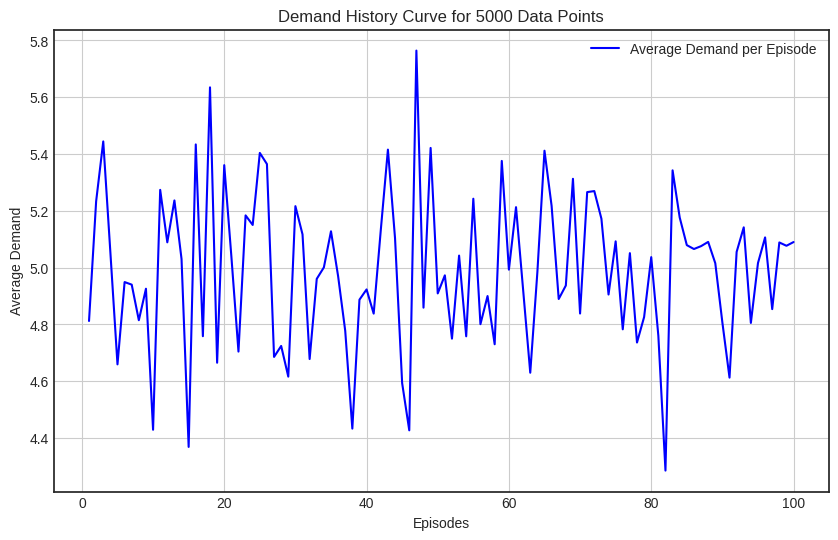

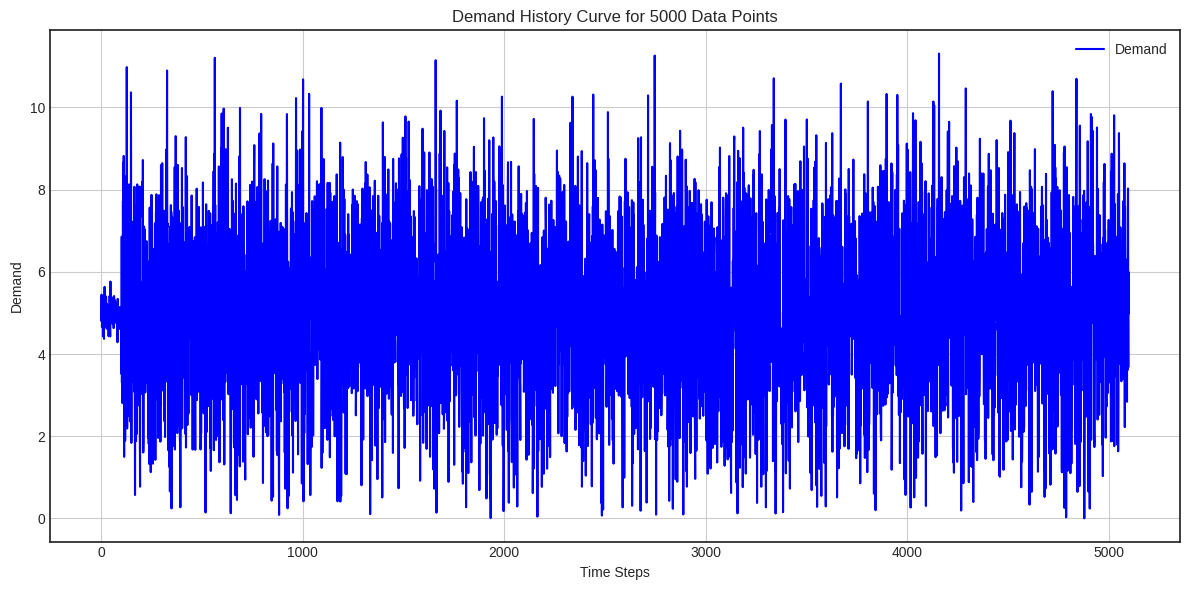

In [6]:
# Simulation Parameters
episodes = 100
steps_per_episode = 50

demand_history = []  # Store demand for all episodes

# Run simulation for demand data points
for episode in range(episodes):
    episode_demand = []
    demand_generator = config['demand_generator']
    for t in range(steps_per_episode):
        demand = demand_generator.next()
        episode_demand.append(demand)
    demand_history.append(np.mean(episode_demand))

# Create x-axis labels for episodes
x = np.arange(1, episodes + 1)

# Plot the demand history curve
plt.figure(figsize=(10, 6))
plt.plot(x, demand_history, label="Average Demand per Episode", color="blue")
plt.title("Demand History Curve for 5000 Data Points")
plt.xlabel("Episodes")
plt.ylabel("Average Demand")
plt.grid(True)
plt.legend()
plt.show()

for episode in range(episodes):
    simulator = SupplyChain(config)
    for t in range(steps_per_episode):
        simulator.act()
    demand_history.extend(simulator.demand)

# Plot demand history
plt.figure(figsize=(12, 6))
x = np.arange(len(demand_history))  # Time steps
plt.plot(x, demand_history, label="Demand", color="blue")
plt.title("Demand History Curve for 5000 Data Points")
plt.xlabel("Time Steps")
plt.ylabel("Demand")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
#
# Helper functions for performance metrics calculation based on the simulation traces
#
def get_holding_costs(supply_chain):
    return np.sum(supply_chain._holding_costs)

def get_fixed_transaction_costs(supply_chain):
    return np.sum(supply_chain._fixed_tx_costs)

def get_fill_rate(supply_chain):
    return 1 - np.sum(np.array(supply_chain.demand) - np.array(supply_chain._filled_demand)) / np.sum(supply_chain.demand)

def get_cycle_service_level(supply_chain):
    n_cycles, n_stock_outs = 0, 0
    is_stock_out = False
    lost_demand = np.array(supply_chain.demand) - np.array(supply_chain._filled_demand)
    for t in range(supply_chain.t):
        if supply_chain.orders[t] != 0 or t == supply_chain.t - 1:
            n_cycles += 1
            if is_stock_out:
                n_stock_outs += 1
            is_stock_out = False

        if lost_demand[t] != 0:
            is_stock_out = True

    return n_cycles, n_stock_outs, 1 - n_stock_outs/n_cycles

Cost-Optimal Review Period R and S(upto stcok level) in (R,S) policy


trial

In [8]:
# Define optimal ranges for R and S
R_range = np.concatenate((np.arange(1, 11, 1), np.arange(11, 51, 5)))  # Finer granularity for small R, coarser for large R
S_range = np.concatenate((np.arange(10, 101, 10), np.arange(101, 501, 20), np.arange(501, 1001, 50)))  # Dynamic step sizes

# To store results
results = []

# Grid search for R and S
for R in R_range:
    for S in S_range:
        config['policy'] = RSInventoryPolicy(R, S)  # Use RS policy with current R and S
        total_cost = 0

        # Simulate episodes
        for episode in range(100):  # Assuming 100 episodes
            simulator = SupplyChain(config)
            for t in range(50):  # Assuming 50 timesteps per episode
                simulator.act()

            # Calculate total cost for this episode
            total_cost += (
                sum(simulator._fixed_tx_costs) +
                sum(simulator._variable_tx_costs) +
                sum(simulator._holding_costs)
            )

        # Average cost over episodes
        avg_cost = total_cost / 100
        results.append((R, S, avg_cost))

# Find the optimal R and S based on minimum cost
optimal = min(results, key=lambda x: x[2])
print(f"Optimal R: {optimal[0]}, Optimal S: {optimal[1]}, Minimum Average Cost: {optimal[2]}")


Optimal R: 46, Optimal S: 10, Minimum Average Cost: 41.20072318384431


In [9]:
# Define ranges for R and S
R_range = np.concatenate((np.arange(1, 11, 1), np.arange(11, 51, 5)))  # Dynamic granularity for R
S_range = np.concatenate((np.arange(10, 101, 10), np.arange(101, 501, 20), np.arange(501, 1001, 50)))  # Dynamic granularity for S

# Function to evaluate metrics for each simulation
def evaluate_metrics(simulator):
    holding_cost = np.sum(simulator._holding_costs)
    fixed_cost = np.sum(simulator._fixed_tx_costs)
    total_cost = holding_cost + fixed_cost
    fill_rate = get_fill_rate(simulator)
    cycle_service_level = get_cycle_service_level(simulator)[-1]
    return holding_cost, fixed_cost, total_cost, fill_rate, cycle_service_level

# Function to perform grid search for R and S
def evaluate_scenarios(n_simulations, n_sim_steps, R_range, S_range, config):
    trace_dims = (len(R_range) * len(S_range), n_simulations)

    # Initialize arrays for metrics
    holding_costs = np.zeros(trace_dims)
    fixed_costs = np.zeros(trace_dims)
    total_costs = np.zeros(trace_dims)
    fill_rates = np.zeros(trace_dims)
    service_levels = np.zeros(trace_dims)

    results = []

    for i, R in enumerate(R_range):
        for j, S in enumerate(S_range):
            config['policy'] = RSInventoryPolicy(R, S)  # Use RS policy
            index = i * len(S_range) + j

            for k in range(n_simulations):
                simulator = SupplyChain(config)
                for t in range(n_sim_steps):
                    simulator.act()

                # Calculate metrics for this simulation
                holding_cost, fixed_cost, total_cost, fill_rate, service_level = evaluate_metrics(simulator)
                holding_costs[index][k] = holding_cost
                fixed_costs[index][k] = fixed_cost
                total_costs[index][k] = total_cost
                fill_rates[index][k] = fill_rate
                service_levels[index][k] = service_level

            # Aggregate metrics
            avg_holding_cost = np.mean(holding_costs[index])
            avg_fixed_cost = np.mean(fixed_costs[index])
            avg_total_cost = np.mean(total_costs[index])
            avg_fill_rate = np.mean(fill_rates[index])
            avg_service_level = np.mean(service_levels[index])

            results.append({
                'R': R,
                'S': S,
                'avg_holding_cost': avg_holding_cost,
                'avg_fixed_cost': avg_fixed_cost,
                'avg_total_cost': avg_total_cost,
                'avg_fill_rate': avg_fill_rate,
                'avg_service_level': avg_service_level
            })

    return results, holding_costs, fixed_costs, total_costs, fill_rates, service_levels

# Simulation configuration
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': FoldedNormalGenerator(5, 0.5),
    'lead_time_generator': FoldedNormalGenerator(0, 0.5),
    'policy': None
}

# Parameters
n_simulations = 100
n_sim_steps = 50

# Run simulations
evaluation_results, holding_costs, fixed_costs, total_costs, fill_rates, service_levels = evaluate_scenarios(n_simulations, n_sim_steps, R_range, S_range, config)

# Find optimal configuration based on total cost
optimal = min(evaluation_results, key=lambda x: x['avg_total_cost'])
print(f"Optimal R: {optimal['R']}, Optimal S: {optimal['S']}, Minimum Average Total Cost: {optimal['avg_total_cost']}")
print(f"Avg Holding Cost: {optimal['avg_holding_cost']}, Avg Fixed Cost: {optimal['avg_fixed_cost']}")
print(f"Avg Fill Rate: {optimal['avg_fill_rate']}, Avg Service Level: {optimal['avg_service_level']}")

# Re-evaluate metrics using optimal R and S
def evaluate_optimal_metrics(optimal_R, optimal_S, n_simulations, n_sim_steps, config):
    config['policy'] = RSInventoryPolicy(optimal_R, optimal_S)

    holding_costs = []
    fixed_costs = []
    total_costs = []
    fill_rates = []
    service_levels = []

    for _ in range(n_simulations):
        simulator = SupplyChain(config)
        for t in range(n_sim_steps):
            simulator.act()

        # Collect metrics
        holding_cost, fixed_cost, total_cost, fill_rate, service_level = evaluate_metrics(simulator)
        holding_costs.append(holding_cost)
        fixed_costs.append(fixed_cost)
        total_costs.append(total_cost)
        fill_rates.append(fill_rate)
        service_levels.append(service_level)

    # Compute averages
    avg_holding_cost = np.mean(holding_costs)
    avg_fixed_cost = np.mean(fixed_costs)
    avg_total_cost = np.mean(total_costs)
    avg_fill_rate = np.mean(fill_rates)
    avg_service_level = np.mean(service_levels)

    print("\nMetrics for Optimal Configuration:")
    print(f"Optimal R: {optimal_R}, Optimal S: {optimal_S}")
    print(f"Avg Holding Cost: {avg_holding_cost}, Avg Fixed Cost: {avg_fixed_cost}")
    print(f"Avg Total Cost: {avg_total_cost}, Avg Fill Rate: {avg_fill_rate}, Avg Service Level: {avg_service_level}")

# Evaluate metrics for the optimal R and S
evaluate_optimal_metrics(optimal['R'], optimal['S'], n_simulations, n_sim_steps, config)



Optimal R: 36, Optimal S: 10, Minimum Average Total Cost: 21.043712619450304
Avg Holding Cost: 1.0437126194503032, Avg Fixed Cost: 20.0
Avg Fill Rate: 0.08016764620992203, Avg Service Level: 0.3333333333333335

Metrics for Optimal Configuration:
Optimal R: 36, Optimal S: 10
Avg Holding Cost: 1.0606520731592755, Avg Fixed Cost: 20.0
Avg Total Cost: 21.060652073159275, Avg Fill Rate: 0.08002265783942264, Avg Service Level: 0.3333333333333335


36 10 [ 1  2  3  4  5  6  7  8  9 10 11 16 21 26 31 36 41 46] [ 10  20  30  40  50  60  70  80  90 100 101 121 141 161 181 201 221 241
 261 281 301 321 341 361 381 401 421 441 461 481 501 551 601 651 701 751
 801 851 901 951]


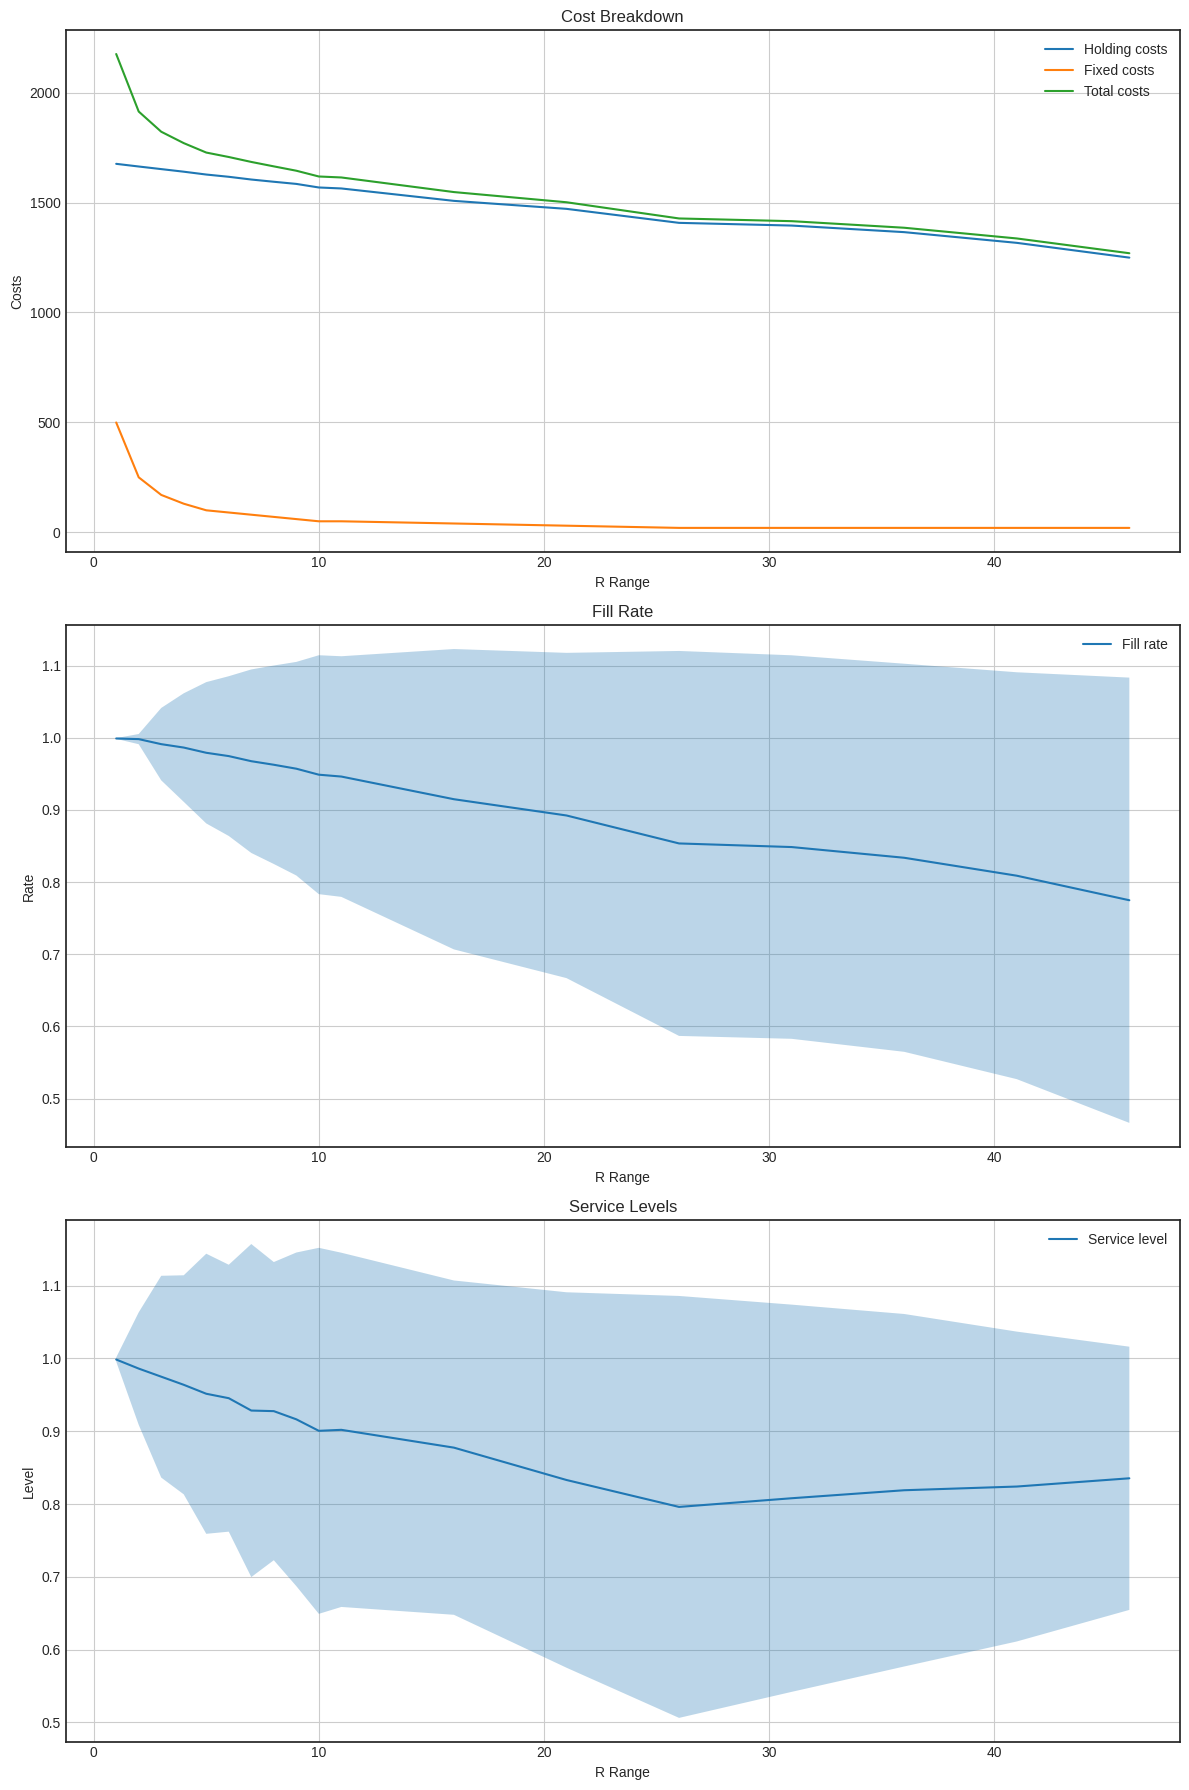

In [15]:
# Visualization of results
def plot_results(results, R_range, S_range):
    total_costs = np.array([res['avg_total_cost'] for res in results]).reshape(len(R_range), len(S_range))
    fill_rates = np.array([res['avg_fill_rate'] for res in results]).reshape(len(R_range), len(S_range))
    service_levels = np.array([res['avg_service_level'] for res in results]).reshape(len(R_range), len(S_range))

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Total cost plot
    avg_holding_costs = np.array([res['avg_holding_cost'] for res in results]).reshape(len(R_range), len(S_range))
    avg_fixed_costs = np.array([res['avg_fixed_cost'] for res in results]).reshape(len(R_range), len(S_range))

    x = R_range
    axs[0].plot(x, np.mean(avg_holding_costs, axis=1), label='Holding costs')
    axs[0].plot(x, np.mean(avg_fixed_costs, axis=1), label='Fixed costs')
    axs[0].plot(x, np.mean(total_costs, axis=1), label='Total costs')
    axs[0].set_title("Cost Breakdown")
    axs[0].set_xlabel("R Range")
    axs[0].set_ylabel("Costs")
    axs[0].legend()
    axs[0].grid(True)

    # Fill rate plot
    axs[1].plot(x, np.mean(fill_rates, axis=1), label='Fill rate')
    axs[1].fill_between(x, np.mean(fill_rates, axis=1) - np.std(fill_rates, axis=1), np.mean(fill_rates, axis=1) + np.std(fill_rates, axis=1), alpha=0.3)
    axs[1].set_title("Fill Rate")
    axs[1].set_xlabel("R Range")
    axs[1].set_ylabel("Rate")
    axs[1].legend()
    axs[1].grid(True)

    # Service level plot
    axs[2].plot(x, np.mean(service_levels, axis=1), label='Service level')
    axs[2].fill_between(x, np.mean(service_levels, axis=1) - np.std(service_levels, axis=1), np.mean(service_levels, axis=1) + np.std(service_levels, axis=1), alpha=0.3)
    axs[2].set_title("Service Levels")
    axs[2].set_xlabel("R Range")
    axs[2].set_ylabel("Level")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

print(optimal['R'], optimal['S'],R_range, S_range)
plot_results(evaluation_results, R_range, S_range)

WITH PENALTY

In [17]:
# Define stockout penalty
penalty_per_unit = 5  # Stockout penalty per unit of unmet demand

# Updated helper functions for cost calculation
def calculate_stockout_costs(simulator, penalty_per_unit):
    """
    Calculate stockout costs based on unmet demand and penalty per unit.
    """
    unmet_demand = np.array(simulator.demand) - np.array(simulator._filled_demand)
    stockout_cost = penalty_per_unit * np.sum(unmet_demand)
    return stockout_cost

def evaluate_metrics_with_stockout(simulator, penalty_per_unit):
    """
    Evaluate metrics including stockout costs for the simulator.
    """
    holding_cost = np.sum(simulator._holding_costs)
    fixed_cost = np.sum(simulator._fixed_tx_costs)
    variable_cost = np.sum(simulator._variable_tx_costs)
    stockout_cost = calculate_stockout_costs(simulator, penalty_per_unit)
    total_cost = holding_cost + fixed_cost + variable_cost + stockout_cost
    fill_rate = get_fill_rate(simulator)
    service_level = get_cycle_service_level(simulator)[-1]
    return holding_cost, fixed_cost, variable_cost, stockout_cost, total_cost, fill_rate, service_level

# Modify the optimization loop to include stockout costs
results_with_stockout = []

for R in R_range:
    for S in S_range:
        config['policy'] = RSInventoryPolicy(R, S)  # Use RS policy with current R and S

        total_costs_with_stockout = []

        for episode in range(n_simulations):
            simulator = SupplyChain(config)
            for t in range(n_sim_steps):
                simulator.act()

            # Calculate metrics including stockout costs for this episode
            holding_cost, fixed_cost, variable_cost, stockout_cost, total_cost, fill_rate, service_level = evaluate_metrics_with_stockout(
                simulator, penalty_per_unit
            )

            total_costs_with_stockout.append(total_cost)

        # Aggregate results across episodes
        avg_total_cost = np.mean(total_costs_with_stockout)

        # Collect results for this R and S
        results_with_stockout.append({
            'R': R,
            'S': S,
            'avg_total_cost': avg_total_cost,
            'avg_holding_cost': holding_cost,
            'avg_fixed_cost': fixed_cost,
            'avg_variable_cost': variable_cost,
            'avg_stockout_cost': stockout_cost,
            'avg_fill_rate': fill_rate,
            'avg_service_level': service_level
        })

# Find the optimal R and S based on minimum total cost including stockout costs
optimal_with_stockout = min(results_with_stockout, key=lambda x: x['avg_total_cost'])

# Print results
print("\nOptimal Configuration Including Stockout Costs:")
print(f"Optimal R: {optimal_with_stockout['R']}, Optimal S: {optimal_with_stockout['S']}")
print(f"Minimum Average Total Cost: {optimal_with_stockout['avg_total_cost']}")
print(f"Avg Holding Cost: {optimal_with_stockout['avg_holding_cost']}, Avg Fixed Cost: {optimal_with_stockout['avg_fixed_cost']}")
print(f"Avg Variable Cost: {optimal_with_stockout['avg_variable_cost']}, Avg Stockout Cost: {optimal_with_stockout['avg_stockout_cost']}")
print(f"Avg Fill Rate: {optimal_with_stockout['avg_fill_rate']}, Avg Service Level: {optimal_with_stockout['avg_service_level']}")



Optimal Configuration Including Stockout Costs:
Optimal R: 10, Optimal S: 50
Minimum Average Total Cost: 430.7311347504432
Avg Holding Cost: 110.52146798015906, Avg Fixed Cost: 50
Avg Variable Cost: 248.83838645349715, Avg Stockout Cost: 18.86268804098586
Avg Fill Rate: 0.9850527311411648, Avg Service Level: 0.5


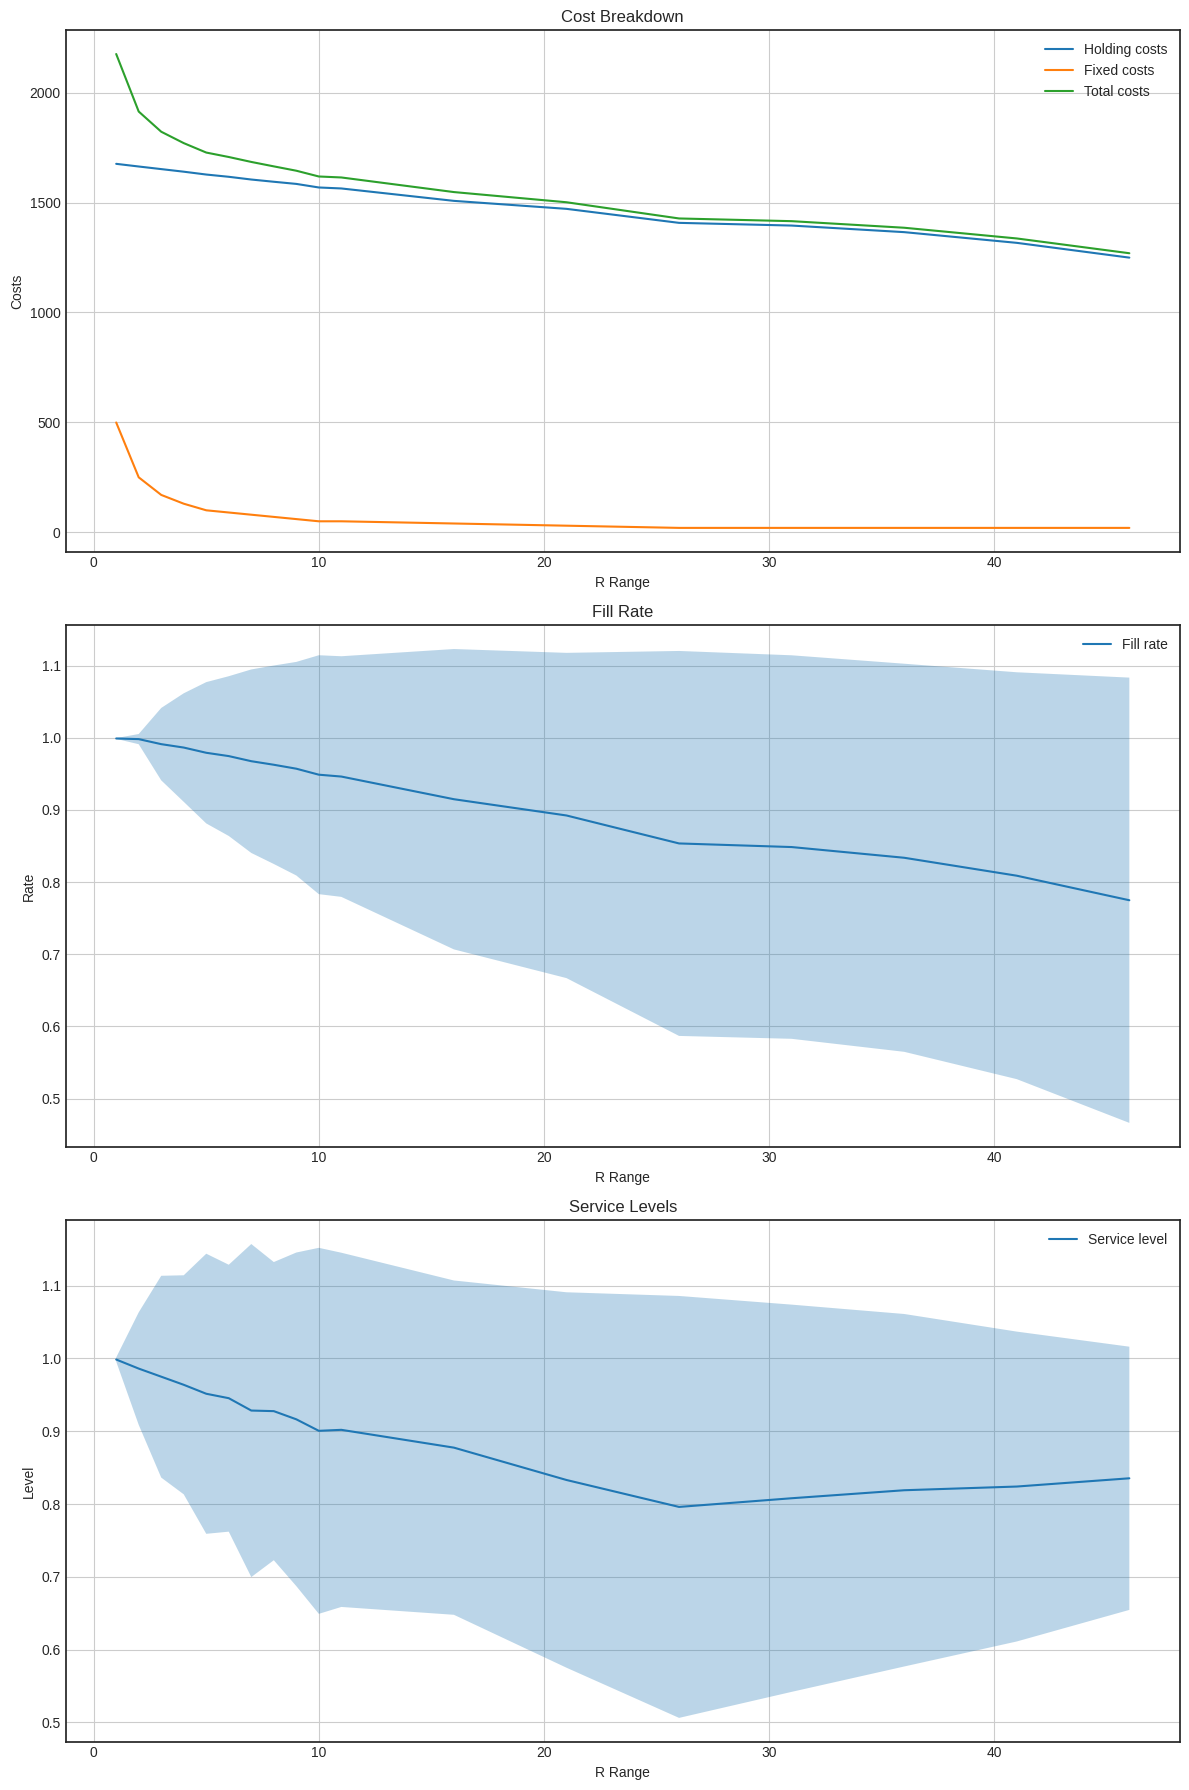

In [18]:
# Visualization of results

plot_results(evaluation_results, R_range, S_range)

heatmaps (interdependencies in 2d)

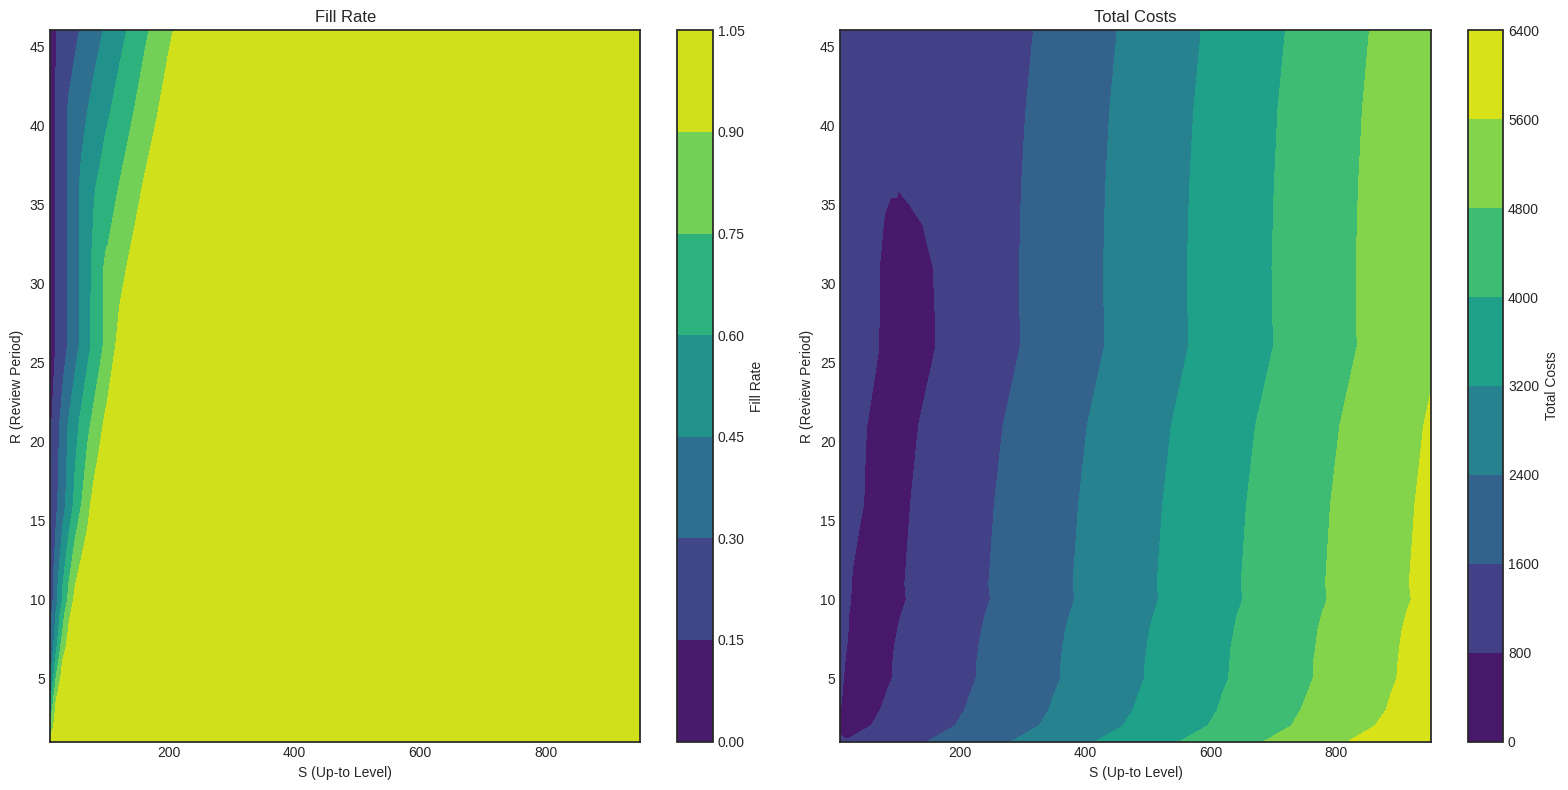

In [19]:
# Function to evaluate metrics in a 2D grid
def evaluate_scenarios_2d(n_simulations, n_sim_steps, R_range, S_range, config_grid):
    fill_rates = np.zeros((len(R_range), len(S_range)))
    total_costs = np.zeros((len(R_range), len(S_range)))

    for i, R in enumerate(R_range):
        for j, S in enumerate(S_range):
            config = config_grid[i][j]
            total_cost, fill_rate = 0, 0

            # Run simulations for each R and S
            for _ in range(n_simulations):
                simulator = SupplyChain(config)
                for t in range(n_sim_steps):
                    simulator.act()

                # Accumulate metrics
                total_cost += (
                    sum(simulator._fixed_tx_costs)
                    + sum(simulator._variable_tx_costs)
                    + sum(simulator._holding_costs)
                    + calculate_stockout_costs(simulator, penalty_per_unit=5)
                )
                fill_rate += get_fill_rate(simulator)

            # Average metrics over simulations
            fill_rates[i][j] = fill_rate / n_simulations
            total_costs[i][j] = total_cost / n_simulations

    return fill_rates, total_costs

# Function to plot performance in 2D
def plot_performance_2d(fill_rates, total_costs, R_range, S_range):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot Fill Rate
    ax1 = axs[0]
    c1 = ax1.contourf(S_range, R_range, fill_rates, cmap='viridis')
    fig.colorbar(c1, ax=ax1, label='Fill Rate')
    ax1.set_title("Fill Rate")
    ax1.set_xlabel("S (Up-to Level)")
    ax1.set_ylabel("R (Review Period)")

    # Plot Total Costs
    ax2 = axs[1]
    c2 = ax2.contourf(S_range, R_range, total_costs, cmap='viridis')
    fig.colorbar(c2, ax=ax2, label='Total Costs')
    ax2.set_title("Total Costs")
    ax2.set_xlabel("S (Up-to Level)")
    ax2.set_ylabel("R (Review Period)")

    plt.tight_layout()
    plt.show()


# Create configuration grid for all combinations of R and S
config_grid = np.empty((len(R_range), len(S_range)), dtype=object)
for i, R in enumerate(R_range):
    for j, S in enumerate(S_range):
        config_grid[i][j] = {
            'fixed_transaction_cost': 10,
            'variable_transaction_cost': 1,
            'holding_cost': 0.1,
            'demand_generator': FoldedNormalGenerator(5, 2),
            'lead_time_generator': FoldedNormalGenerator(0, 1),
            'policy': RSInventoryPolicy(R, S),
        }

# Simulation parameters
n_simulations = 100  # Number of simulations
n_sim_steps = 50    # Number of timesteps per simulation

# Run evaluations
fill_rates, total_costs = evaluate_scenarios_2d(n_simulations, n_sim_steps, R_range, S_range, config_grid)

# Plot results
plot_performance_2d(fill_rates, total_costs, R_range, S_range)
